# Preprocesamiento de Imágenes

In [3]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# descomentar si se usa Colab
# from google.colab import drive 
# drive.mount('/content/drive')

In [ ]:
# Agregar src al path
sys.path.append(os.path.abspath('../src'))
#sys.path.append(os.path.abspath('/content/TIC_CNN_Modelo_Melanoma/src')) # Descomentar si se usa Colab


from config.config import CSV_SPLIT_FOLDER, BATCH_SIZE, IMAGE_SIZE
from data import create_data_generators, create_data_flow_from_dataframe

### 1. Cargar los datasets divididos

In [20]:
# Cargar los CSVs generados anteriormente
train_df = pd.read_csv(os.path.join(CSV_SPLIT_FOLDER, "train.csv"))
val_df = pd.read_csv(os.path.join(CSV_SPLIT_FOLDER, "val.csv"))
test_df = pd.read_csv(os.path.join(CSV_SPLIT_FOLDER, "test.csv"))

# Convertir a string para compatibilidad con Keras
train_df['label'] = train_df['label'].astype(str) 
val_df['label'] = val_df['label'].astype(str) 
test_df['label'] = test_df['label'].astype(str) 

print(f"Train: {len(train_df)} imágenes")
print(f"Val: {len(val_df)} imágenes")
print(f"Test: {len(test_df)} imágenes")

Train: 11691 imágenes
Val: 2505 imágenes
Test: 2506 imágenes


### 2. Crear generadores de datos

Los generadores aplican:
- **Train**: Augmentation (rotación, zoom, flips) + Normalización ImageNet
- **Val/Test**: Solo normalización ImageNet

In [21]:
train_datagen, val_test_datagen = create_data_generators()

print("Generadores creados:")
print(" - Train: con augmentation")
print(" - Val/Test: solo normalización")

Generadores creados:
 - Train: con augmentation
 - Val/Test: solo normalización


### 3. Crear flujos de datos

In [22]:
train_generator = create_data_flow_from_dataframe(
    train_datagen, 
    train_df, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_generator = create_data_flow_from_dataframe(
    val_test_datagen, 
    val_df, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

test_generator = create_data_flow_from_dataframe(
    val_test_datagen, 
    test_df, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print(f"\nFlujos creados con batch_size={BATCH_SIZE}")
print(f"Train steps per epoch: {len(train_generator)}")
print(f"Val steps per epoch: {len(val_generator)}")
print(f"Test steps: {len(test_generator)}")

Found 11691 validated image filenames belonging to 2 classes.
Found 2505 validated image filenames belonging to 2 classes.
Found 2506 validated image filenames belonging to 2 classes.

Flujos creados con batch_size=32
Train steps per epoch: 366
Val steps per epoch: 79
Test steps: 79


### 4. Visualizar ejemplos de augmentation

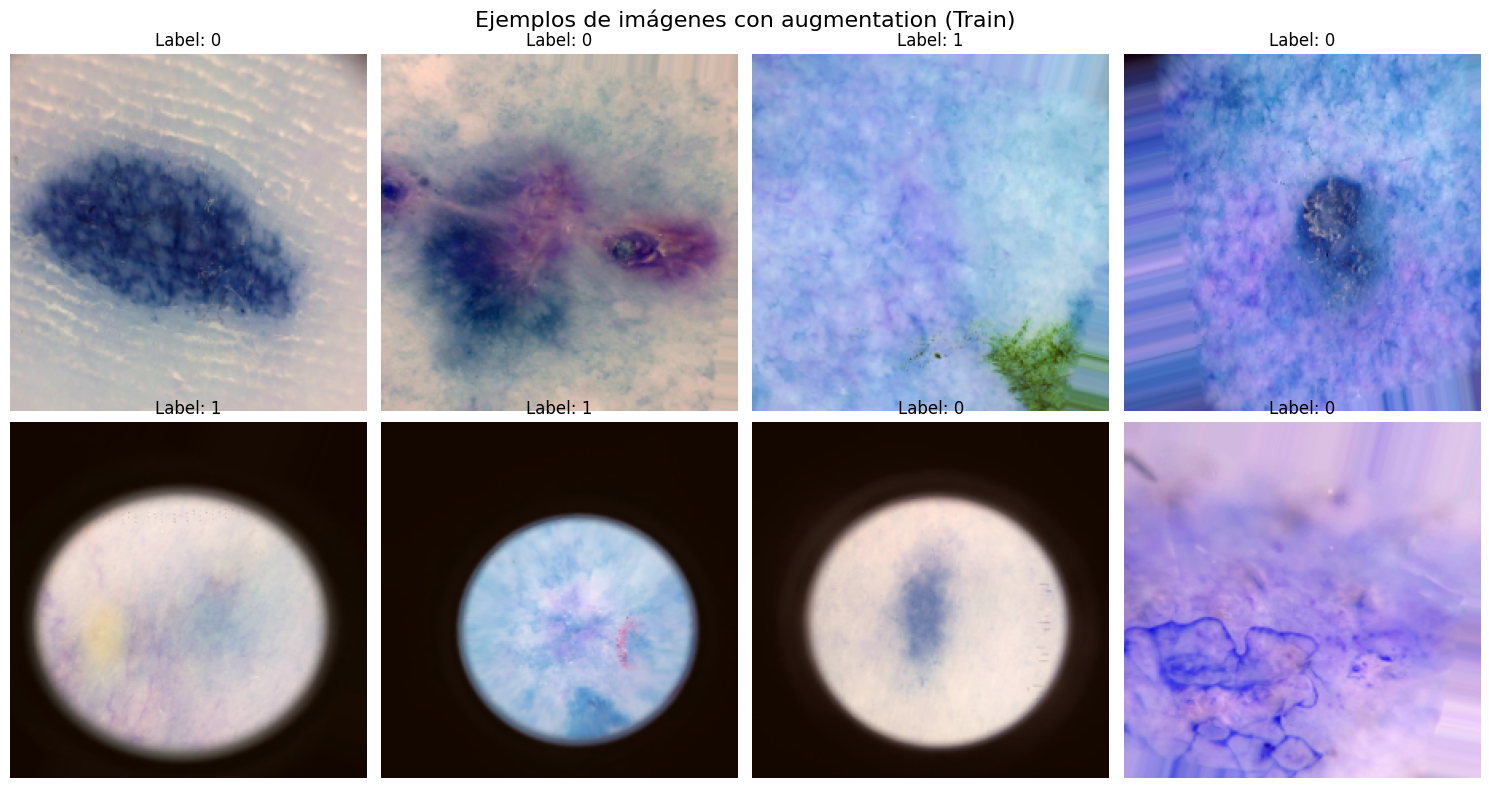

In [23]:
# Obtener un batch de entrenamiento
sample_batch_x, sample_batch_y = next(train_generator)

# Visualizar 8 imágenes con augmentation
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    # Denormalizar para visualización (aproximado)
    img = sample_batch_x[i]
    img = (img - img.min()) / (img.max() - img.min())
    
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {int(sample_batch_y[i])}")
    axes[i].axis('off')

plt.suptitle('Ejemplos de imágenes con augmentation (Train)', fontsize=16)
plt.tight_layout()
plt.show()

### 5. Verificar forma de los datos

In [24]:
print(f"Forma del batch de imágenes: {sample_batch_x.shape}")
print(f"Forma del batch de etiquetas: {sample_batch_y.shape}")
print(f"Target size configurado: {IMAGE_SIZE}")
print(f"\nRango de valores después de preprocesamiento:")
print(f"  Min: {sample_batch_x.min():.2f}")
print(f"  Max: {sample_batch_x.max():.2f}")
print(f"  Mean: {sample_batch_x.mean():.2f}")

Forma del batch de imágenes: (32, 224, 224, 3)
Forma del batch de etiquetas: (32,)
Target size configurado: (224, 224)

Rango de valores después de preprocesamiento:
  Min: -123.68
  Max: 145.32
  Mean: 16.43


### 6. Ejemplo de preprocesamiento individual (para inferencia)

In [26]:
from data import load_and_preprocess_image

# Tomar una imagen de ejemplo
example_path = train_df['filepath'].iloc[0]
print(f"Procesando: {example_path}")

# Preprocesar para inferencia
processed_img = load_and_preprocess_image(example_path)

print(f"\nForma procesada: {processed_img.shape}")
print(f"Lista para modelo: {processed_img.shape == (1, *IMAGE_SIZE, 3)}")

Procesando: ../data/ISIC-images/ISIC_0068466.jpg

Forma procesada: (1, 224, 224, 3)
Lista para modelo: True


### 7. Limpieza de artefactos

- Eliminación de pelos usando morfología.

In [ ]:
# TODO: Implementar limpieza de artefactos